# Commodity Price Prediction - Complete Demo

Pipeline:
1. **Load & Validate** data
2. **Clean & Preprocess** (auto-detect frequency)
3. **Feature Engineering** (44 features)
4. **Train/Test Split** (chronological 80/20)
5. **Model Training** (Baseline + 6 ML models)
6. **Evaluation & Comparison**
7. **Future Price Forecast** (N-day ahead)

In [1]:
# === Setup ===
import warnings
warnings.filterwarnings('ignore')

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print(f'Project root: {PROJECT_ROOT}')
print(f'Python: {sys.version}')

Project root: d:\Work\Comodity-Price-Forecasting
Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


## 1. Load & Validate Data

In [2]:
from src.ingestion.loader import CommodityLoader
from src.ingestion.validator import DataValidator

loader = CommodityLoader()
validator = DataValidator()

commodities = loader.list_commodities()
print(f'Available commodities ({len(commodities)}):')
for c in commodities:
    print(f"  - {c['id']:12s}  {c['name']}")

Available commodities (14):
  - crude_oil     Crude Oil (WTI)
  - coffee        Coffee Arabica
  - corn          Corn
  - cotton        Cotton
  - gas           Gas
  - milk          Milk
  - oil           Oil
  - pork          Pork
  - pvc           Pvc
  - rubber        Rubber
  - rice          Rice
  - steel         Steel
  - sugar         Sugar
  - urea          Urea


In [3]:
# Load all commodities summary
summary_rows = []
for c in commodities:
    try:
        df = loader.load_commodity(c['id'])
        report = validator.validate(df, c['id'])
        summary_rows.append({
            'commodity': c['id'], 'name': c['name'], 'rows': len(df),
            'start': str(df['date'].min().date()), 'end': str(df['date'].max().date()),
            'valid': report.passed,
        })
    except Exception as e:
        summary_rows.append({'commodity': c['id'], 'name': c['name'], 'rows': 0, 'valid': False})

pd.DataFrame(summary_rows)

2026-02-12 10:48:19.816 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 261 records for crude_oil
2026-02-12 10:48:19.834 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2556 records for coffee
2026-02-12 10:48:19.896 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2542 records for corn
2026-02-12 10:48:19.955 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2598 records for cotton
2026-02-12 10:48:20.015 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2544 records for gas
2026-02-12 10:48:20.070 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2555 records for milk
2026-02-12 10:48:20.131 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 10:48:20.198 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 3015 records for pork
2026-02-12 10:48:20.318 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 352 records for pvc
2026-02-12 10:48:20.328 | INFO   

,commodity,name,rows,start,end,valid
0,crude_oil,Crude Oil (WTI),261,2024-01-02,2024-12-31,True
1,coffee,Coffee Arabica,2556,2016-01-04,2026-02-03,True
2,corn,Corn,2542,2016-01-04,2026-02-03,True
3,cotton,Cotton,2598,2016-01-04,2026-02-03,True
4,gas,Gas,2544,2016-01-04,2026-02-03,True
5,milk,Milk,2555,2016-01-04,2026-02-03,True
6,oil,Oil,2616,2016-01-04,2026-02-03,True
7,pork,Pork,3015,2016-01-04,2025-12-31,False
8,pvc,Pvc,352,2024-11-22,2026-01-16,True
9,rubber,Rubber,1489,2020-01-03,2026-02-05,True


In [4]:
# ===== CHOOSE COMMODITY =====
COMMODITY_ID = 'oil'  # <-- Change this to any commodity
# ============================

df_raw = loader.load_commodity(COMMODITY_ID)
print(f'Loaded {COMMODITY_ID}: {len(df_raw)} rows')
print(f'Date range: {df_raw["date"].min().date()} to {df_raw["date"].max().date()}')
df_raw.head()

2026-02-12 10:48:26.939 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil


Loaded oil: 2616 rows
Date range: 2016-01-04 to 2026-02-03


,date,close,commodity_id
0,2016-01-04,37.35,oil
1,2016-01-05,36.77,oil
2,2016-01-06,34.72,oil
3,2016-01-07,34.07,oil
4,2016-01-08,33.77,oil


In [5]:
report = validator.validate(df_raw, COMMODITY_ID)
print(report.summary())

Validation Report for oil
Status: ✅ PASSED
Errors: 0, Warnings: 0
--------------------------------------------------
✅ required_columns: All required columns present
✅ date_parseable: All dates are parseable
✅ date_unique: All dates are unique
✅ date_chronological: Dates are in chronological order
✅ close_numeric: Close values are numeric
✅ close_positive: All close values are non-negative
✅ close_not_null: No null close values
✅ missing_dates: 31 missing dates (1.2%)
✅ outliers: 1 potential outliers detected (z > 4.0)
✅ min_history: 2616 records (>= 200)


## 2. Clean & Preprocess

In [6]:
from src.preprocessing.cleaner import DataCleaner
from src.preprocessing.transformer import TargetTransformer

cleaner = DataCleaner(frequency='auto', fill_method='ffill', max_gap_days=10)
df_clean = cleaner.clean(df_raw)

quality = cleaner.get_quality_summary(df_clean)
print(f'Cleaned: {quality["total_rows"]} rows')
print(f'Original: {quality["original_rows"]} ({quality["original_pct"]:.1%})')
print(f'Imputed:  {quality["imputed_rows"]} ({quality["imputed_pct"]:.1%})')
print(f'Missing:  {quality["missing_rows"]}, Outliers: {quality["outlier_rows"]}')

transformer = TargetTransformer(method='none')
df_transformed = transformer.transform(df_clean)
df_clean.head()

2026-02-12 10:48:33.942 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)


Cleaned: 2632 rows
Original: 2601 (98.8%)
Imputed:  31 (1.2%)
Missing:  0, Outliers: 0


,date,close,commodity_id,is_original,missing_streak,is_imputed,is_outlier,z_score
0,2016-01-04,37.35,oil,True,0,False,False,1.894470
1,2016-01-05,36.77,oil,True,0,False,False,1.765754
2,2016-01-06,34.72,oil,True,0,False,False,1.045385
3,2016-01-07,34.07,oil,True,0,False,False,0.782691
4,2016-01-08,33.77,oil,True,0,False,False,0.593454


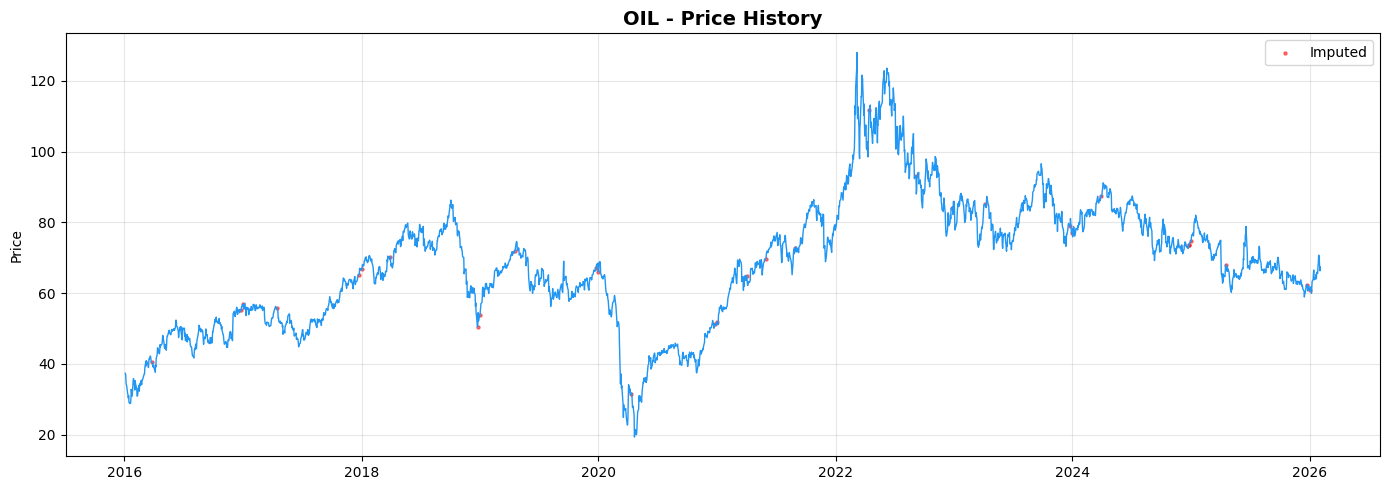

In [7]:
# Plot price history
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_clean['date'], df_clean['close'], color='#2196F3', linewidth=1)
if 'is_imputed' in df_clean.columns:
    imp = df_clean[df_clean['is_imputed'] == True]
    if len(imp) > 0:
        ax.scatter(imp['date'], imp['close'], color='red', s=5, alpha=0.5, label='Imputed')
        ax.legend()
ax.set_title(f'{COMMODITY_ID.upper()} - Price History', fontsize=14, fontweight='bold')
ax.set_ylabel('Price'); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

## 3. Feature Engineering

In [8]:
from src.features.generator import FeatureGenerator

fg = FeatureGenerator(
    lag_days=[1, 2, 3, 5, 7, 14, 21, 30],
    rolling_windows=[7, 14, 30, 60],
    rolling_stats=['mean', 'std', 'min', 'max'],
    calendar_features=True,
    volatility_features=True,
)

df_features = fg.generate(df_transformed)
feature_names = fg.get_feature_names()
print(f'Generated {len(feature_names)} features, shape: {df_features.shape}')

# Show sample
sample_cols = ['date', 'close', 'lag_1', 'lag_7', 'rolling_mean_7', 'volatility_7', 'return_1d', 'month']
df_features[[c for c in sample_cols if c in df_features.columns]].tail(5)

Generated 52 features, shape: (2632, 62)


,date,close,lag_1,lag_7,rolling_mean_7,volatility_7,return_1d,month
2627,2026-01-28,68.40,67.57,63.94,65.314286,0.017914,0.012284,1
2628,2026-01-29,70.71,68.40,64.92,65.951429,0.017329,0.033772,1
2629,2026-01-30,70.69,70.71,65.24,66.778571,0.019566,-0.000283,1
2630,2026-02-02,66.30,70.69,64.06,67.557143,0.019995,-0.062102,2
2631,2026-02-03,67.33,66.30,65.88,67.877143,0.033370,0.015535,2


## 4. Train/Test Split

In [9]:
from src.preprocessing.splitter import TimeSeriesSplitter

ml_feature_cols = [c for c in feature_names if c in df_features.columns]
df_ml = df_features.dropna(subset=ml_feature_cols + ['close']).copy()
print(f'Rows after dropping NaN: {len(df_ml)}')

splitter = TimeSeriesSplitter(train_ratio=0.8, min_test_days=30)
split = splitter.split(df_ml)
train_df, test_df = split.train_df, split.test_df
print(split.summary())

X_train, y_train = train_df[ml_feature_cols], train_df['close']
X_test,  y_test  = test_df[ml_feature_cols],  test_df['close']

# Validation set for early stopping
val_size = int(len(X_train) * 0.1)
X_tr, X_val = X_train.iloc[:-val_size], X_train.iloc[-val_size:]
y_tr, y_val = y_train.iloc[:-val_size], y_train.iloc[-val_size:]

print(f'\nX_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}')

2026-02-12 10:48:43.718 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2081 rows, test=521 rows, gap=0, split_date=2024-02-05 00:00:00


Rows after dropping NaN: 2602
Train: 2016-02-15 00:00:00 -> 2024-02-05 00:00:00 (2081 rows)
Test:  2024-02-06 00:00:00 -> 2026-02-03 00:00:00 (521 rows)
Gap:   0 days

X_train: (2081, 52), X_val: (208, 52), X_test: (521, 52)


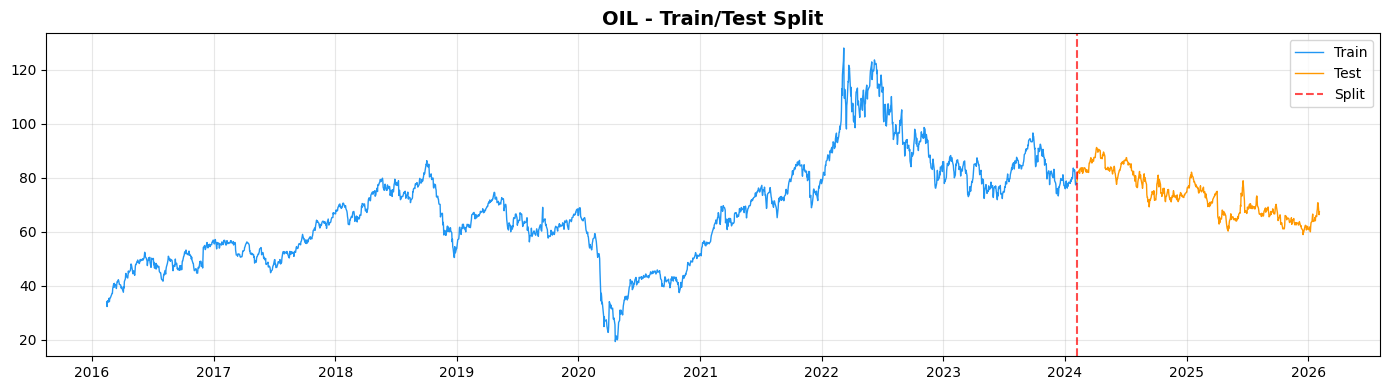

In [10]:
# Visualize split
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train_df['date'], y_train, color='#2196F3', label='Train', linewidth=1)
ax.plot(test_df['date'], y_test, color='#FF9800', label='Test', linewidth=1)
ax.axvline(x=train_df['date'].iloc[-1], color='red', linestyle='--', alpha=0.7, label='Split')
ax.set_title(f'{COMMODITY_ID.upper()} - Train/Test Split', fontsize=14, fontweight='bold')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

## 5. Model Training

### 5.1 Baseline Models

In [11]:
from src.models.baseline import NaiveModel, SeasonalNaiveModel, DriftModel, MeanModel
from src.evaluation.metrics import calculate_metrics

baselines = {
    'Naive': NaiveModel(),
    'Seasonal Naive (7d)': SeasonalNaiveModel(season_length=7),
    'Drift': DriftModel(),
    'Mean (30d)': MeanModel(window=30),
}

baseline_results = {}
baseline_preds = {}
for name, model in baselines.items():
    model.fit(y_train)
    preds = model.predict(len(y_test))
    metrics = calculate_metrics(y_test.values, preds, y_train.values)
    baseline_results[name] = metrics
    baseline_preds[name] = preds
    print(f'{name:25s} | MAE={metrics["mae"]:8.2f} | MAPE={metrics["mape"]:5.2f}%')

Naive                     | MAE=    7.98 | MAPE=11.50%
Seasonal Naive (7d)       | MAE=    9.38 | MAPE=13.68%
Drift                     | MAE=   12.66 | MAPE=18.54%
Mean (30d)                | MAE=    8.38 | MAPE=12.15%


### 5.2 ML Models (XGBoost, LightGBM, RandomForest)

In [12]:
from src.models.ml import XGBoostForecaster, LightGBMForecaster, RandomForestForecaster

ml_models = {}
ml_results = {}
ml_preds = {}

# --- XGBoost ---
try:
    xgb = XGBoostForecaster(n_estimators=500, max_depth=6, learning_rate=0.05)
    xgb.fit(y_tr, X_tr, X_val=X_val, y_val=y_val)
    p = xgb.predict(X=X_test)
    ml_models['XGBoost'] = xgb
    ml_results['XGBoost'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['XGBoost'] = p
    print(f"XGBoost:      MAE={ml_results['XGBoost']['mae']:.2f}  MAPE={ml_results['XGBoost']['mape']:.2f}%")
except Exception as e:
    print(f'XGBoost failed: {e}')

# --- LightGBM ---
try:
    lgb = LightGBMForecaster(n_estimators=500, max_depth=6, learning_rate=0.05)
    lgb.fit(y_tr, X_tr, X_val=X_val, y_val=y_val)
    p = lgb.predict(X=X_test)
    ml_models['LightGBM'] = lgb
    ml_results['LightGBM'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['LightGBM'] = p
    print(f"LightGBM:     MAE={ml_results['LightGBM']['mae']:.2f}  MAPE={ml_results['LightGBM']['mape']:.2f}%")
except Exception as e:
    print(f'LightGBM failed: {e}')

# --- RandomForest ---
try:
    rf = RandomForestForecaster(n_estimators=200, max_depth=10)
    rf.fit(y_train, X_train)
    p = rf.predict(X=X_test)
    ml_models['RandomForest'] = rf
    ml_results['RandomForest'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['RandomForest'] = p
    print(f"RandomForest: MAE={ml_results['RandomForest']['mae']:.2f}  MAPE={ml_results['RandomForest']['mape']:.2f}%")
except Exception as e:
    print(f'RandomForest failed: {e}')

2026-02-12 10:49:00.394 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features


XGBoost:      MAE=0.28  MAPE=0.39%


2026-02-12 10:49:02.506 | INFO     | src.models.ml:fit:264 - LightGBM fitted with 52 features


LightGBM:     MAE=0.27  MAPE=0.36%


2026-02-12 10:49:04.610 | INFO     | src.models.ml:fit:341 - RandomForest fitted with 52 features


RandomForest: MAE=0.27  MAPE=0.38%


### 5.3 Advanced Models (CatBoost, ElasticNet, SVR)

In [ ]:
#%pip install catboost

  Using cached plotly-6.5.2-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-2.16.0-py3-none-any.whl.metadata (14 kB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.4 MB 357.1 kB/s eta 0:04:46
   ---------------------------------------- 0.5/102.4 MB 357.1 kB/s eta 0:04:46
   ---------------------------------------- 0.8/102.4 MB 430.1 kB/s eta 0:03:57
   ---------------------------------------- 0.8/102.4 MB 430.1 kB/s eta 0:03:57
   ---------------------------------------- 0.8/102.4 MB 430.1 kB/s eta 0:03:57
   ---------------------------------------- 1.

In [13]:
from src.models.ml_advanced import CatBoostForecaster, ElasticNetForecaster, SVRForecaster

# --- CatBoost ---
try:
    cb = CatBoostForecaster(iterations=500, depth=6, learning_rate=0.05)
    cb.fit(y_tr, X_tr, X_val=X_val, y_val=y_val)
    p = cb.predict(X=X_test)
    ml_models['CatBoost'] = cb
    ml_results['CatBoost'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['CatBoost'] = p
    print(f"CatBoost:     MAE={ml_results['CatBoost']['mae']:.2f}  MAPE={ml_results['CatBoost']['mape']:.2f}%")
except ImportError:
    print('CatBoost not installed. Run: pip install catboost')
except Exception as e:
    print(f'CatBoost failed: {e}')

# --- ElasticNet ---
try:
    en = ElasticNetForecaster(alpha=1.0, l1_ratio=0.5)
    en.fit(y_train, X_train)
    p = en.predict(X=X_test)
    ml_models['ElasticNet'] = en
    ml_results['ElasticNet'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['ElasticNet'] = p
    print(f"ElasticNet:   MAE={ml_results['ElasticNet']['mae']:.2f}  MAPE={ml_results['ElasticNet']['mape']:.2f}%")
except Exception as e:
    print(f'ElasticNet failed: {e}')

# --- SVR ---
try:
    svr = SVRForecaster(C=100.0, epsilon=0.1)
    svr.fit(y_train, X_train)
    p = svr.predict(X=X_test)
    ml_models['SVR'] = svr
    ml_results['SVR'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['SVR'] = p
    print(f"SVR:          MAE={ml_results['SVR']['mae']:.2f}  MAPE={ml_results['SVR']['mape']:.2f}%")
except Exception as e:
    print(f'SVR failed: {e}')

2026-02-12 10:49:14.550 | INFO     | src.models.ml_advanced:fit:86 - CatBoost fitted with 52 features
2026-02-12 10:49:14.563 | INFO     | src.models.ml_advanced:fit:174 - ElasticNet fitted with 52 features


CatBoost:     MAE=0.67  MAPE=0.92%
ElasticNet:   MAE=1.04  MAPE=1.44%


2026-02-12 10:49:15.082 | INFO     | src.models.ml_advanced:fit:264 - SVR fitted with 52 features


SVR:          MAE=0.38  MAPE=0.51%


## 6. Model Comparison

In [14]:
all_results = {**baseline_results, **ml_results}
results_df = pd.DataFrame(all_results).T.sort_values('mae')

print('=== Model Comparison (sorted by MAE) ===')
results_df[['mae', 'rmse', 'mape', 'smape', 'mase']].round(4)

=== Model Comparison (sorted by MAE) ===


,mae,rmse,mape,smape,mase
LightGBM,0.2694,0.3588,0.3627,0.3626,0.2484
RandomForest,0.2747,0.4623,0.3774,0.3772,0.2533
XGBoost,0.2841,0.4002,0.3875,0.3872,0.2620
SVR,0.3772,0.5669,0.5084,0.5107,0.3478
CatBoost,0.6665,0.8349,0.9208,0.9165,0.6145
ElasticNet,1.0421,1.3199,1.4352,1.4292,0.9609
Naive,7.9760,9.2641,11.4968,10.7894,7.3542
Mean (30d),8.3766,9.7796,12.1518,11.2956,7.7236
Seasonal Naive (7d),9.3804,11.1116,13.6833,12.5168,8.6492
Drift,12.6624,14.9534,18.5389,16.4342,11.6753


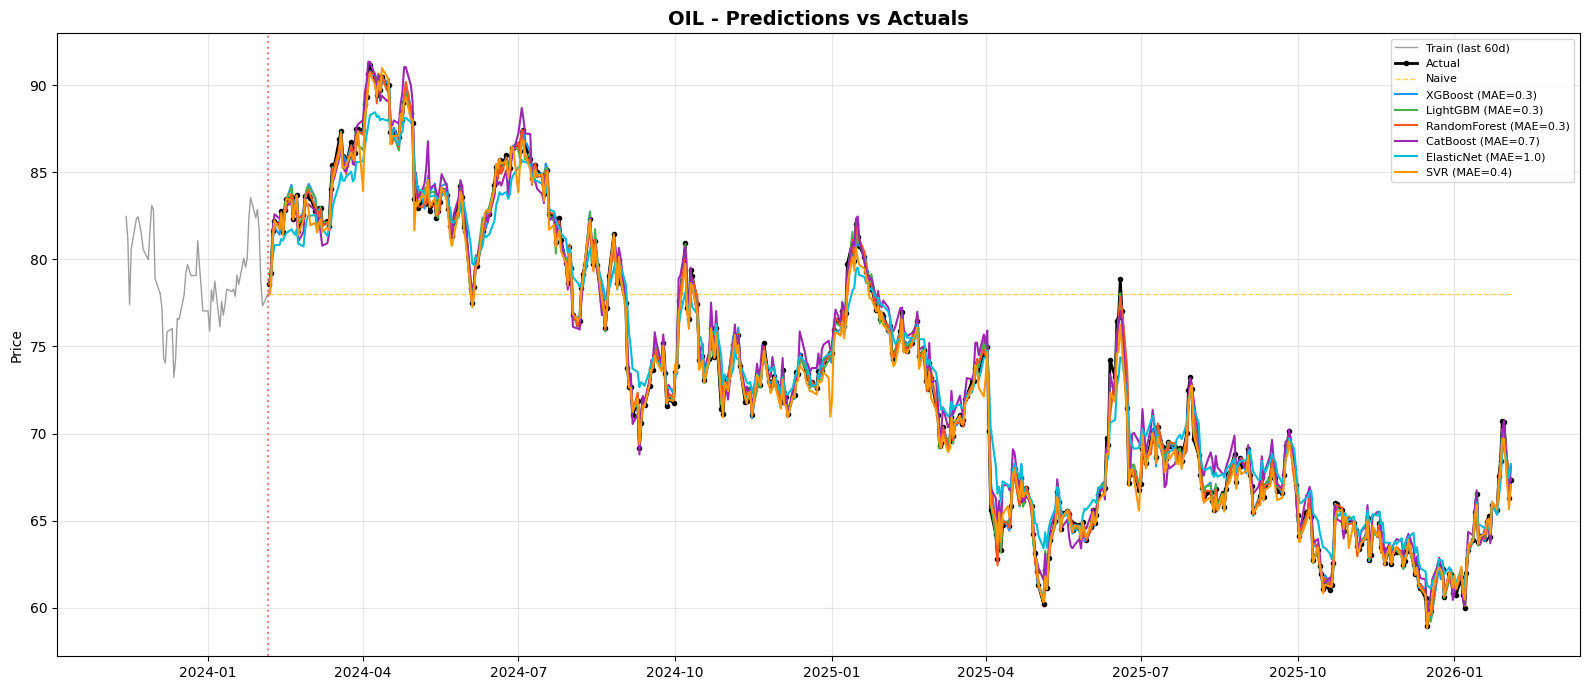

In [15]:
fig, ax = plt.subplots(figsize=(16, 7))

test_dates = test_df['date'].values
train_tail = train_df.tail(60)
ax.plot(train_tail['date'], train_tail['close'], color='#9E9E9E', linewidth=1, label='Train (last 60d)')
ax.plot(test_dates, y_test.values, color='black', linewidth=2, label='Actual', marker='o', markersize=3)

# Baseline
ax.plot(test_dates, baseline_preds['Naive'], color='#FFC107', linewidth=1, linestyle='--', alpha=0.7, label='Naive')

# ML models with colors
ml_colors = {'XGBoost':'#2196F3', 'LightGBM':'#4CAF50', 'RandomForest':'#FF5722',
             'CatBoost':'#9C27B0', 'ElasticNet':'#00BCD4', 'SVR':'#FF9800'}
for name, preds in ml_preds.items():
    mae = ml_results[name]['mae']
    ax.plot(test_dates, preds, color=ml_colors.get(name,'gray'), linewidth=1.5,
            label=f'{name} (MAE={mae:.1f})')

ax.axvline(x=train_df['date'].iloc[-1], color='red', linestyle=':', alpha=0.5)
ax.set_title(f'{COMMODITY_ID.upper()} - Predictions vs Actuals', fontsize=14, fontweight='bold')
ax.set_ylabel('Price'); ax.legend(loc='best', fontsize=8); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

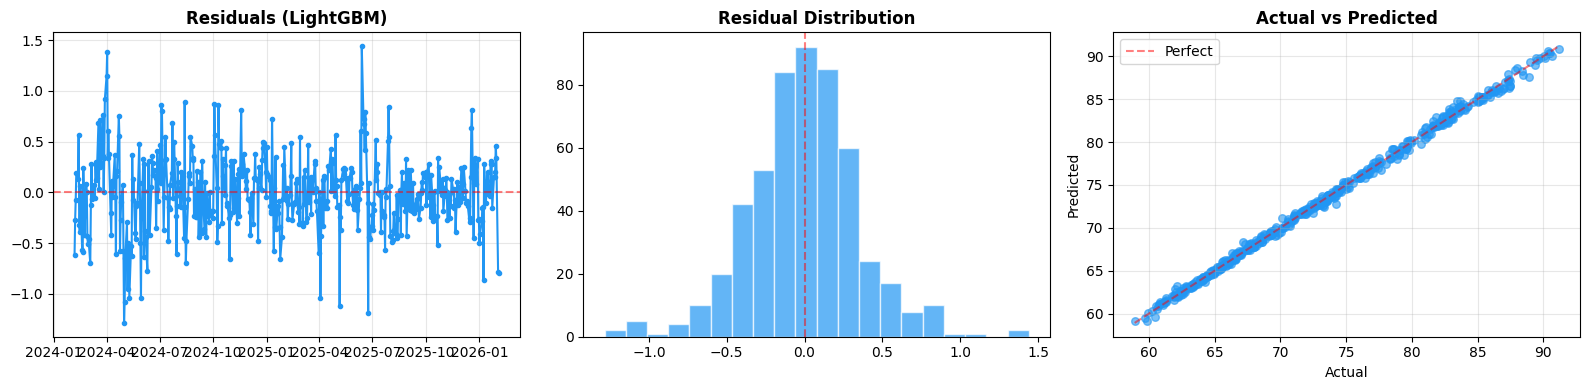

In [16]:
# Residual analysis for best model
best_name = results_df.index[0]
best_p = ml_preds.get(best_name, baseline_preds.get(best_name))
residuals = y_test.values - best_p

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(test_dates, residuals, 'o-', markersize=3, color='#2196F3')
axes[0].axhline(0, color='red', ls='--', alpha=0.5)
axes[0].set_title(f'Residuals ({best_name})', fontweight='bold'); axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=20, color='#2196F3', edgecolor='white', alpha=0.7)
axes[1].axvline(0, color='red', ls='--', alpha=0.5)
axes[1].set_title('Residual Distribution', fontweight='bold')

axes[2].scatter(y_test.values, best_p, color='#2196F3', alpha=0.6, s=30)
lim = [min(y_test.min(), best_p.min()), max(y_test.max(), best_p.max())]
axes[2].plot(lim, lim, 'r--', alpha=0.5, label='Perfect')
axes[2].set_title('Actual vs Predicted', fontweight='bold')
axes[2].set_xlabel('Actual'); axes[2].set_ylabel('Predicted'); axes[2].legend(); axes[2].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

### 5.7 Hyperparameter Optimization (ML Models)

We optimize the best performing ML model using RandomizedSearchCV.

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# 1. Identify best ML model
best_ml_name = min(ml_results, key=lambda k: ml_results[k]['mae'])
print(f"Best ML Model to optimize: {best_ml_name}")

# 2. Define search spaces
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    },
    'LightGBM': {
        'n_estimators': [100, 300, 500, 1000],
        'num_leaves': [20, 31, 50, 100],
        'learning_rate': [0.01, 0.05, 0.1],
        'feature_fraction': [0.6, 0.8, 1.0],
    },
    'RandomForest': {
        'n_estimators': [100, 300, 500],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
    },
    'CatBoost': {
        'iterations': [300, 500, 1000],
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }
}

if best_ml_name in param_grids:
    param_dist = param_grids[best_ml_name]
    base_model = ml_models[best_ml_name].model_  # Underlying sklearn/xgb model
    
    # Randomized Search
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    print(f"Starting optimization for {best_ml_name}...")
    random_search.fit(X_train, y_train)
    
    print(f"Best Params: {random_search.best_params_}")
    print(f"Best CV Score (MAE): {-random_search.best_score_:.4f}")
    
    # Retrain wrapper with best params
    best_model_opt = random_search.best_estimator_
    ml_models[f'{best_ml_name}_Opt'] = ml_models[best_ml_name] # update wrapper ref if needed
    # For simplicity, we just save the optimized result
    opt_preds = best_model_opt.predict(X_test)
    opt_metrics = calculate_metrics(y_test.values, opt_preds, y_train.values)
    ml_results[f'{best_ml_name}_Opt'] = opt_metrics
    ml_preds[f'{best_ml_name}_Opt'] = opt_preds
    
    print(f"Optimized Test MAE: {opt_metrics['mae']:.4f}")
else:
    print(f"Optimization not configured for {best_ml_name}")


Best ML Model to optimize: LightGBM
Starting optimization for LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'num_leaves': 20, 'n_estimators': 300, 'learning_rate': 0.1, 'feature_fraction': 1.0}
Best CV Score (MAE): 3.3092
Optimized Test MAE: 0.2336


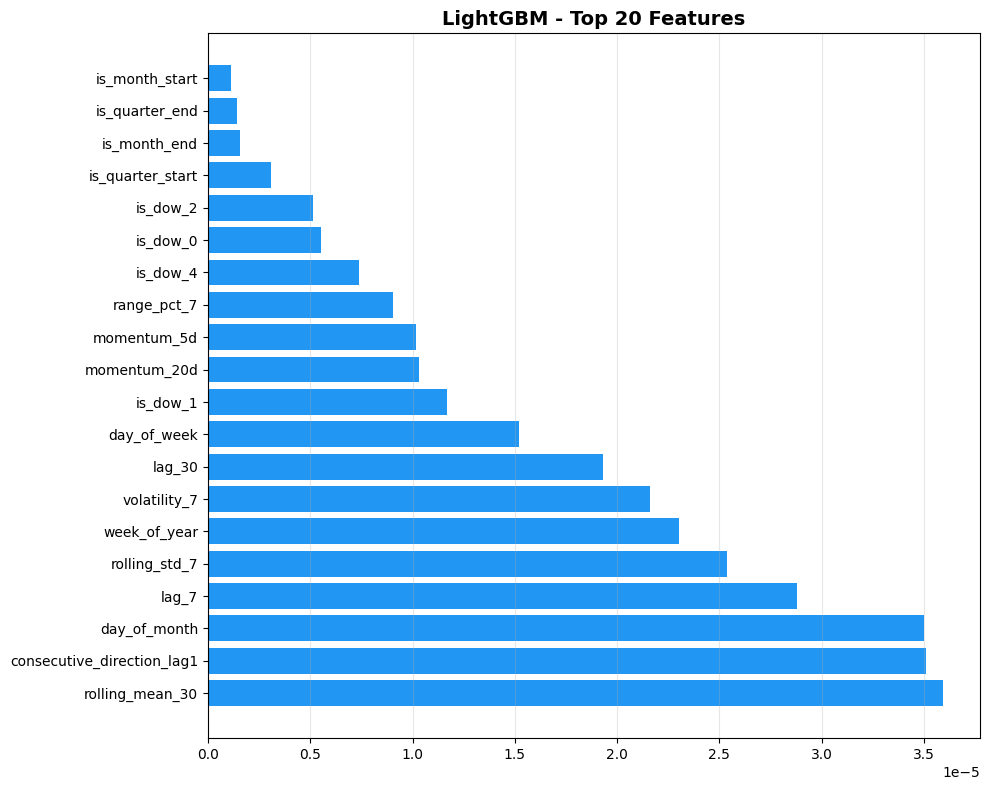

In [32]:
# Feature importance from best tree-based model
tree_models = {k: v for k, v in ml_models.items() if k in ['XGBoost','LightGBM','CatBoost','RandomForest']}
if tree_models:
    best_tree = list(tree_models.values())[0]
    imp = best_tree.get_feature_importance()
    if imp is not None and len(imp) > 0:
        top20 = imp.tail(20) if 'importance' in imp.columns else imp.nlargest(20, imp.columns[-1])
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(top20['feature'], top20['importance'], color='#2196F3')
        ax.set_title(f'{list(tree_models.keys())[1]} - Top 20 Features', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout(); plt.show()

## 9. Future Price Forecast

Predict the next N days into the future starting from the latest available data point.

In [34]:
from src.inference.future_forecaster import FutureForecaster

# Forecast horizon
N_DAYS = 14

# Gather all trained models
all_models = {}
all_models.update(ml_models)
if 'trained_transformers' in locals():
    all_models.update(trained_transformers)

future_results = {}

print(f"Forecasting {N_DAYS} days into the future for {len(all_models)} models...")

for name, model in all_models.items():
    try:
        # Transformer models might need special handling if wrapping isn't perfect
        # but FutureForecaster expects a .predict(X) interface which wrapper provides.
        ff = FutureForecaster()
        # FutureForecaster needs underlying data context potentially
        # Actually forecast_future helper uses latest data from loader?
        # Let's look at FutureForecaster signature from outline.
        # It has prepare_base_data(commodity_id).
        
        # We'll use the convenience method forecast_future if available,
        # or manually use the class.
        # Using the class directly ensures we use the in-memory data if needed.
        
        ff.prepare_base_data(COMMODITY_ID)
        forecast_df = ff.forecast(model, COMMODITY_ID, n_days=N_DAYS)
        
        future_results[name] = forecast_df
        print(f"  \u2705 {name}: {forecast_df['predicted_price'].iloc[-1]:.2f}")
    except Exception as e:
        print(f"  \u274c {name} failed: {e}")


2026-02-12 11:14:10.169 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:10.186 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:10.266 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil


Forecasting 14 days into the future for 7 models...


2026-02-12 11:14:10.269 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:10.334 | INFO     | src.inference.future_forecaster:forecast:112 - Starting 14-day forecast for oil from 2026-02-03 (last price: 67.33)
2026-02-12 11:14:10.544 | INFO     | src.inference.future_forecaster:forecast:185 - Forecast complete: 14 days, last predicted price: 67.99 (+0.98%)
2026-02-12 11:14:10.569 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:10.580 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:10.666 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:10.669 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:10.725 | INFO     | src.inference.future_forec

  ✅ XGBoost: 67.99


2026-02-12 11:14:10.853 | INFO     | src.inference.future_forecaster:forecast:185 - Forecast complete: 14 days, last predicted price: 69.67 (+3.48%)
2026-02-12 11:14:10.870 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:10.878 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:10.974 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:10.982 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:11.045 | INFO     | src.inference.future_forecaster:forecast:112 - Starting 14-day forecast for oil from 2026-02-03 (last price: 67.33)


  ✅ LightGBM: 69.67


2026-02-12 11:14:11.578 | INFO     | src.inference.future_forecaster:forecast:185 - Forecast complete: 14 days, last predicted price: 67.82 (+0.73%)
2026-02-12 11:14:11.592 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:11.596 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:11.649 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:11.652 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:11.708 | INFO     | src.inference.future_forecaster:forecast:112 - Starting 14-day forecast for oil from 2026-02-03 (last price: 67.33)


  ✅ RandomForest: 67.82


2026-02-12 11:14:11.820 | INFO     | src.inference.future_forecaster:forecast:185 - Forecast complete: 14 days, last predicted price: 68.23 (+1.34%)
2026-02-12 11:14:11.829 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:11.834 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:11.891 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:11.897 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:11.962 | INFO     | src.inference.future_forecaster:forecast:112 - Starting 14-day forecast for oil from 2026-02-03 (last price: 67.33)


  ✅ CatBoost: 68.23


2026-02-12 11:14:12.064 | INFO     | src.inference.future_forecaster:forecast:185 - Forecast complete: 14 days, last predicted price: 68.58 (+1.86%)
2026-02-12 11:14:12.076 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:12.081 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:12.129 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:12.132 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:12.192 | INFO     | src.inference.future_forecaster:forecast:112 - Starting 14-day forecast for oil from 2026-02-03 (last price: 67.33)


  ✅ ElasticNet: 68.58


2026-02-12 11:14:12.299 | INFO     | src.inference.future_forecaster:forecast:185 - Forecast complete: 14 days, last predicted price: 65.84 (-2.21%)
2026-02-12 11:14:12.312 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:12.319 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:12.372 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:14:12.378 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:14:12.426 | INFO     | src.inference.future_forecaster:forecast:112 - Starting 14-day forecast for oil from 2026-02-03 (last price: 67.33)


  ✅ SVR: 65.84


2026-02-12 11:14:12.593 | INFO     | src.inference.future_forecaster:forecast:185 - Forecast complete: 14 days, last predicted price: 69.67 (+3.48%)


  ✅ LightGBM_Opt: 69.67


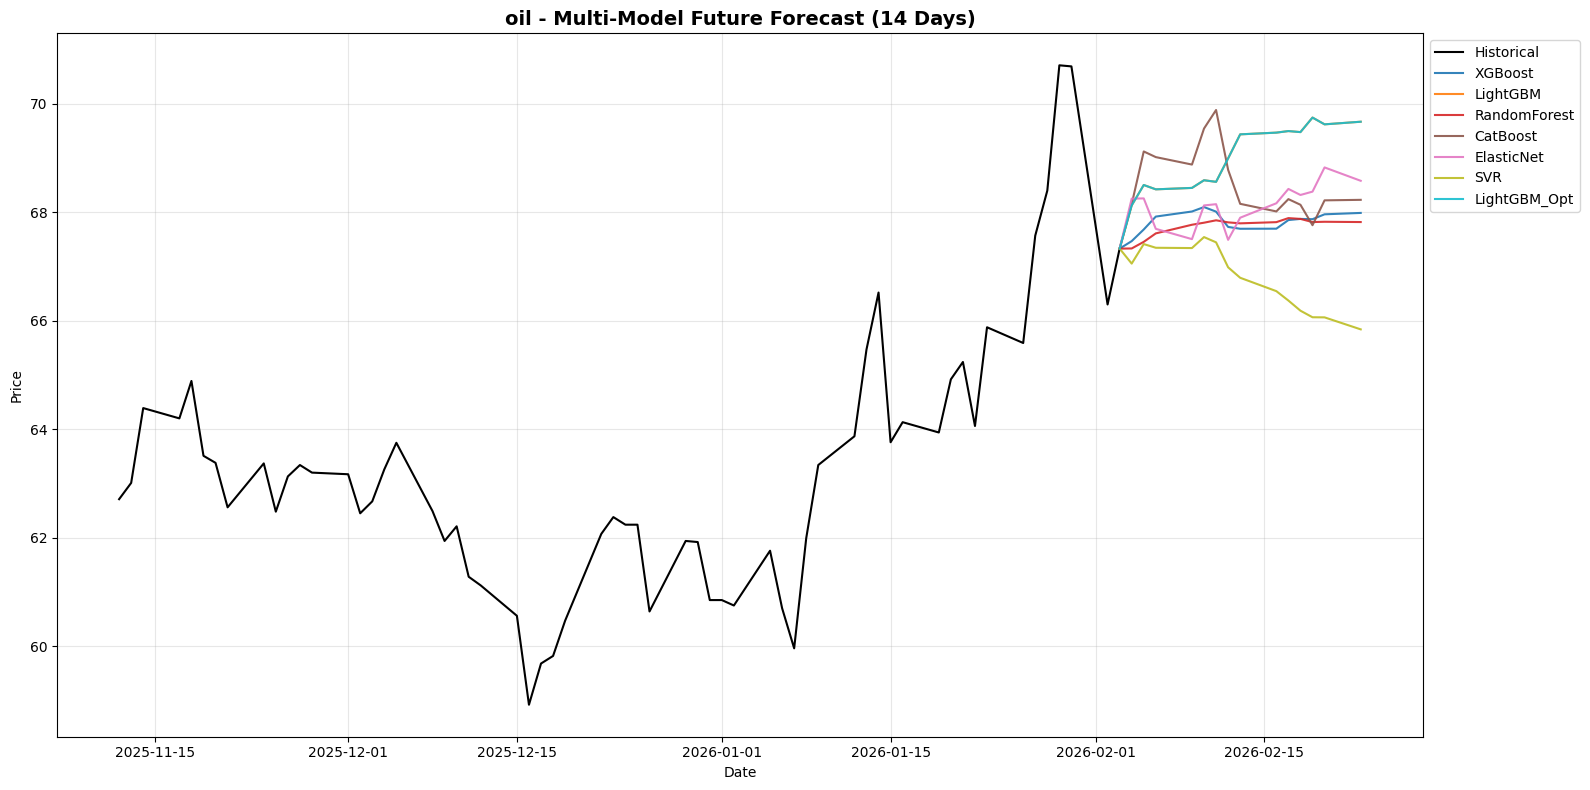

In [35]:
# Visualize All Future Forecasts
fig, ax = plt.subplots(figsize=(16, 8))

# Historical data (last 60 days)
hist_df = df_ml.tail(60)
ax.plot(hist_df['date'], hist_df['close'], color='black', linewidth=1.5, label='Historical')

# Plot forecasts
colors = plt.cm.tab10(np.linspace(0, 1, len(future_results)))
for i, (name, df) in enumerate(future_results.items()):
    dates = df['date']
    prices = df['predicted_price']
    
    # Connect last historical point to first prediction
    last_hist_date = hist_df['date'].iloc[-1]
    last_hist_price = hist_df['close'].iloc[-1]
    
    plot_dates = [last_hist_date] + list(dates)
    plot_prices = [last_hist_price] + list(prices)
    
    ax.plot(plot_dates, plot_prices, label=name, color=colors[i], linewidth=1.5, alpha=0.9)
    
    # Plot CI if available (optional, might be cluttered)
    # if 'ci_lower' in df.columns:
    #     ax.fill_between(dates, df['ci_lower'], df['ci_upper'], color=colors[i], alpha=0.1)

ax.set_title(f'{COMMODITY_ID} - Multi-Model Future Forecast ({N_DAYS} Days)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 10. Batch Train All Commodities

In [39]:
batch_results = []

for c in commodities:
    cid = c['id']
    try:
        df = loader.load_commodity(cid)
        df = cleaner.clean(df)
        df = transformer.transform(df)
        df = fg.generate(df)
        feat_cols = [f for f in fg.get_feature_names() if f in df.columns]
        df = df.dropna(subset=feat_cols + ['close'])
        
        if len(df) < 60:
            batch_results.append({'commodity': cid, 'error': f'Only {len(df)} rows'})
            continue
        
        result = splitter.split(df)
        X_tr_b, y_tr_b = result.train_df[feat_cols], result.train_df['close']
        X_te_b, y_te_b = result.test_df[feat_cols], result.test_df['close']
        
        model = XGBoostForecaster(n_estimators=300, max_depth=6, learning_rate=0.05)
        model.fit(y_tr_b, X_tr_b)
        preds = model.predict(X=X_te_b)
        m = calculate_metrics(y_te_b.values, preds, y_tr_b.values)
        
        batch_results.append({
            'commodity': cid, 'train': len(X_tr_b), 'test': len(X_te_b),
            'mae': m['mae'], 'rmse': m['rmse'], 'mape': m['mape'], 'mase': m.get('mase'),
        })
        print(f'{cid:12s}: MAE={m["mae"]:10.2f}  MAPE={m["mape"]:6.2f}%')
    except Exception as e:
        batch_results.append({'commodity': cid, 'error': str(e)})
        print(f'{cid:12s}: ERROR - {e}')

batch_df = pd.DataFrame(batch_results)
print(f'\nTrained: {batch_df["mae"].notna().sum()}/{len(commodities)}')

2026-02-12 11:19:47.644 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 261 records for crude_oil
2026-02-12 11:19:47.647 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)
2026-02-12 11:19:47.688 | INFO     | src.preprocessing.splitter:split:109 - Split: train=184 rows, test=47 rows, gap=0, split_date=2024-10-25 00:00:00
2026-02-12 11:19:48.026 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:48.042 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2556 records for coffee
2026-02-12 11:19:48.054 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.4% weekend dates)


crude_oil   : MAE=      7.40  MAPE=  4.98%


2026-02-12 11:19:48.333 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2059 rows, test=515 rows, gap=0, split_date=2024-02-13 00:00:00
2026-02-12 11:19:49.002 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:49.019 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2542 records for corn
2026-02-12 11:19:49.031 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.1% weekend dates)
2026-02-12 11:19:49.140 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2081 rows, test=521 rows, gap=0, split_date=2024-02-05 00:00:00


coffee      : MAE=      0.72  MAPE= 19.55%


2026-02-12 11:19:49.756 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:49.774 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2598 records for cotton
2026-02-12 11:19:49.791 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (1.4% weekend dates)
2026-02-12 11:19:49.892 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2081 rows, test=521 rows, gap=0, split_date=2024-02-05 00:00:00


corn        : MAE=      0.02  MAPE=  0.41%


2026-02-12 11:19:50.390 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:50.407 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2544 records for gas
2026-02-12 11:19:50.421 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.1% weekend dates)
2026-02-12 11:19:50.535 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2081 rows, test=521 rows, gap=0, split_date=2024-02-05 00:00:00


cotton      : MAE=      0.00  MAPE=  0.21%


2026-02-12 11:19:51.196 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:51.214 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2555 records for milk
2026-02-12 11:19:51.227 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (1.1% weekend dates)
2026-02-12 11:19:51.323 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2081 rows, test=521 rows, gap=0, split_date=2024-02-05 00:00:00


gas         : MAE=      0.01  MAPE=  0.35%


2026-02-12 11:19:51.948 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:51.967 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-12 11:19:51.983 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.6% weekend dates)
2026-02-12 11:19:52.093 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2081 rows, test=521 rows, gap=0, split_date=2024-02-05 00:00:00


milk        : MAE=      0.09  MAPE=  0.50%


2026-02-12 11:19:52.736 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:52.756 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 3015 records for pork
2026-02-12 11:19:52.769 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)
2026-02-12 11:19:52.878 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2062 rows, test=516 rows, gap=0, split_date=2024-01-09 00:00:00


oil         : MAE=      0.27  MAPE=  0.36%


2026-02-12 11:19:53.509 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:53.524 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 352 records for pvc
2026-02-12 11:19:53.530 | INFO     | src.preprocessing.cleaner:_detect_frequency:111 - Auto-detected calendar frequency (28.4% weekend dates)
2026-02-12 11:19:53.584 | INFO     | src.preprocessing.splitter:split:109 - Split: train=247 rows, test=62 rows, gap=0, split_date=2025-11-15 00:00:00


pork        : MAE=      0.01  MAPE=  0.83%


2026-02-12 11:19:53.984 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:53.997 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 1489 records for rubber
2026-02-12 11:19:54.010 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)
2026-02-12 11:19:54.112 | INFO     | src.preprocessing.splitter:split:109 - Split: train=1248 rows, test=312 rows, gap=0, split_date=2024-11-26 00:00:00


pvc         : MAE=     73.50  MAPE=  1.68%


2026-02-12 11:19:54.831 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:54.851 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2541 records for rice
2026-02-12 11:19:54.865 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)
2026-02-12 11:19:54.976 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2081 rows, test=521 rows, gap=0, split_date=2024-02-05 00:00:00


rubber      : MAE=      4.47  MAPE=  1.37%


2026-02-12 11:19:55.710 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:55.726 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 1533 records for steel
2026-02-12 11:19:55.735 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)
2026-02-12 11:19:55.828 | INFO     | src.preprocessing.splitter:split:109 - Split: train=1249 rows, test=313 rows, gap=0, split_date=2024-11-26 00:00:00


rice        : MAE=      0.13  MAPE=  0.82%


2026-02-12 11:19:56.478 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:56.493 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2599 records for sugar
2026-02-12 11:19:56.506 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (1.3% weekend dates)
2026-02-12 11:19:56.613 | INFO     | src.preprocessing.splitter:split:109 - Split: train=2081 rows, test=521 rows, gap=0, split_date=2024-02-05 00:00:00


steel       : MAE=      5.89  MAPE=  0.68%


2026-02-12 11:19:57.015 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features
2026-02-12 11:19:57.036 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 1440 records for urea
2026-02-12 11:19:57.048 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)
2026-02-12 11:19:57.171 | INFO     | src.preprocessing.splitter:split:109 - Split: train=1109 rows, test=278 rows, gap=0, split_date=2024-10-15 00:00:00


sugar       : MAE=      0.00  MAPE=  0.62%


2026-02-12 11:19:57.825 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features


urea        : MAE=      5.39  MAPE=  1.22%

Trained: 14/14


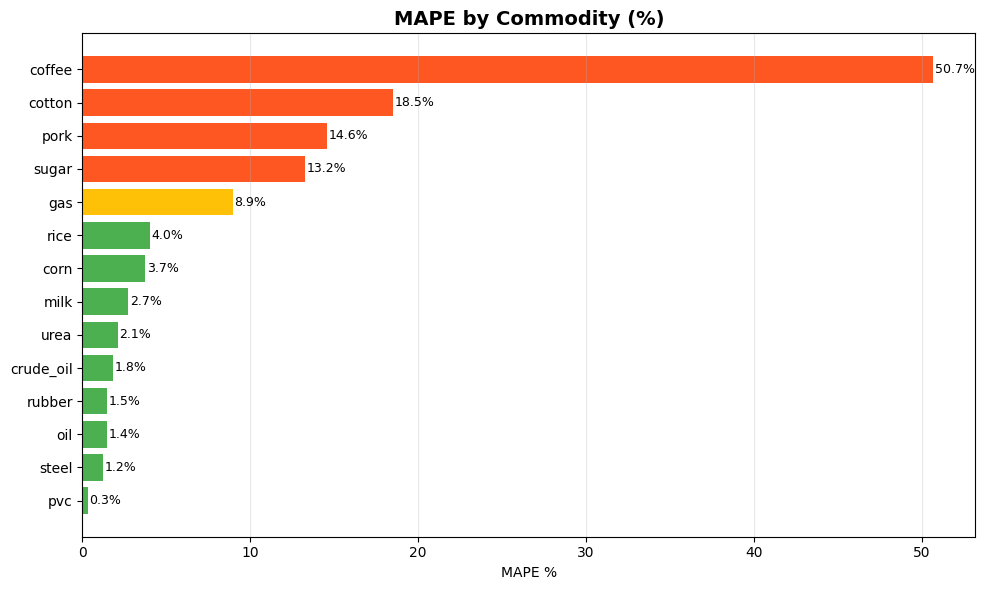

In [38]:
# Batch results chart
valid = batch_df.dropna(subset=['mape']).sort_values('mape')
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4CAF50' if v < 5 else '#FFC107' if v < 10 else '#FF5722' for v in valid['mape']]
ax.barh(valid['commodity'], valid['mape'], color=colors)
ax.set_title('MAPE by Commodity (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('MAPE %'); ax.grid(True, alpha=0.3, axis='x')
for i, (_, row) in enumerate(valid.iterrows()):
    ax.text(row['mape']+0.1, i, f'{row["mape"]:.1f}%', va='center', fontsize=9)
plt.tight_layout(); plt.show()

## 11. Save Model & Predictions

In [ ]:
# Save best model
model_dir = os.path.join(PROJECT_ROOT, 'models', COMMODITY_ID)
os.makedirs(model_dir, exist_ok=True)

if 'best_ml_name' not in locals() or best_ml_name not in ml_models:
    if ml_results:
        best_ml_name = min(ml_results, key=lambda k: ml_results[k]['mae'])
    else:
        raise ValueError('No ML results available to determine best model')

best_model = ml_models[best_ml_name]
save_path = os.path.join(model_dir, f'{best_ml_name.lower()}_best.model')
best_model.save(save_path)
print(f'Best model ({best_ml_name}) saved to: {save_path}')

# Save predictions
pred_path = os.path.join(PROJECT_ROOT, 'data', 'predictions', f'{COMMODITY_ID}_predictions.csv')
os.makedirs(os.path.dirname(pred_path), exist_ok=True)

pred_df = pd.DataFrame({
    'date': test_df['date'].values,
    'actual': y_test.values,
    **{name: preds for name, preds in ml_preds.items()},
})
pred_df.to_csv(pred_path, index=False)
print(f'Predictions saved to: {pred_path}')

# Save future forecasts for all models
fc_dir = os.path.join(PROJECT_ROOT, 'data', 'predictions')
os.makedirs(fc_dir, exist_ok=True)

if 'future_results' in locals() and future_results:
    for model_name, model_fc_df in future_results.items():
        if model_fc_df is None or model_fc_df.empty:
            continue
        fc_path = os.path.join(fc_dir, f'{COMMODITY_ID}_{model_name.lower()}_forecast_{N_DAYS}d.csv')
        model_fc_df.to_csv(fc_path, index=False)
    print(f'Saved future forecasts for {len(future_results)} models to: {fc_dir}')
elif 'forecast_df' in locals() and isinstance(forecast_df, pd.DataFrame) and not forecast_df.empty:
    fc_path = os.path.join(fc_dir, f'{COMMODITY_ID}_forecast_{N_DAYS}d.csv')
    forecast_df.to_csv(fc_path, index=False)
    print(f'Future forecast saved to: {fc_path}')
else:
    print('No future forecast dataframe available to save.')

---
**Done!** Change `COMMODITY_ID` in Section 1 and re-run all cells for a different commodity.